# Notebook title

In [18]:
import numpy as np
import pandas as pd

from collections import defaultdict
import os

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score

In this notebook, we work with the *adult income* dataset. ***Skriv preamble***

Start by loading in the data and doing some initial processing.

In [19]:
FIG_PATH = 'reports/figs/'
def savefig(fname, dpi=None):
    dpi = 150 if dpi == None else dpi
    plt.savefig(os.path.join(FIG_PATH, fname), bbox_inches='tight', dpi=dpi)

In [20]:
income = pd.read_csv('data/income.csv')
income['target'] = income.income.map({'<=50K': 0, '>50K': 1})

# make protected attributes binary
income['gender_group'] = income.gender.map({'Male': 0, 'Female': 1})

income.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,target,gender_group
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,0,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,0,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K,1,0
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,1,0
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K,0,1


In [21]:
# define nominal features, numerical features, target and protected attributes
nom_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country']
num_features = ['educational-num']
target = 'target'
groups = 'gender_group'

In [22]:
# define a preprocessing pipeline and split data into train and test
preprocessing = ColumnTransformer(
    [('onehotencoder', OneHotEncoder(handle_unknown='ignore'), nom_features),
     ('standardscaler', StandardScaler(), num_features)
     ])

income_train, income_test = train_test_split(income, test_size=0.2, random_state=42)

We define a binary logistic regression model. We implement it in pytorch as a single feed forward layer followed by sigmoid. We also implement a fit method for training the classifier.

In [23]:
class BinaryLogisticRegression(nn.Module):
    def __init__(self,
                 in_dim: int):
        super().__init__()
        
        self.linear = nn.Linear(in_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        return self.sigmoid(self.linear(x)).flatten()
    
    def fit(self, x, y, batch_size=64, n_iter=10):
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

        trainloader = DataLoader(TensorDataset(x, y), batch_size=batch_size, shuffle=True)
        
        for epoch in range(n_iter):
            for x, y in trainloader:
                y_pred = self(x)
                loss = criterion(y_pred, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


### Baseline
For future reference, we start by making a baseline model without any fairness considerations to see what the performance and fairness of the model looks like.

In [24]:
def equalized_odds(y_true, y_pred, groups):
    mask = groups == 0
    return y_pred[mask & (y_true == 1)].mean(), y_pred[~mask & (y_true == 1)].mean()

class KfoldTracker:
    def __init__(self):
        self.performance = defaultdict(list)
        self.fairness = defaultdict(list)
        self.feature_importance = defaultdict(list)

    def log_performance(self, y_true, y_pred):
        self.performance['Accuracy'].append(accuracy_score(y_true, y_pred))
        self.performance['Balanced accuracy'].append(balanced_accuracy_score(y_true, y_pred))
        self.performance['f1-score'].append(f1_score(y_true, y_pred))
        self.performance['ROC AUC'].append(roc_auc_score(y_true, y_pred))

    def log_fairness(self, y_true, y_pred, groups):
        tpr_g1, tpr_g2 = equalized_odds(y_true, y_pred, groups)
        self.fairness['TPR G1'].append(tpr_g1)
        self.fairness['TPR G2'].append(tpr_g2)

    def log_feature_importance(self, feature_importance, feature_names):
        for i, name in enumerate(feature_names):
            self.feature_importance[name].append(feature_importance[i])
        for key in self.feature_importance.keys():
            if key not in feature_names:
                self.feature_importance[key].append(np.nan)

    def log(self, y_true, y_pred, groups, feature_importance, feature_names):
        self.log_performance(y_true, y_pred)
        self.log_fairness(y_true, y_pred, groups)
        self.log_feature_importance(feature_importance, feature_names)

    def get_mean_performance(self):
        return {k: (np.mean(v), np.std(v)) for k, v in self.performance.items()}
    
    def get_mean_fairness(self):
        return {k: (np.mean(v), np.std(v)) for k, v in self.fairness.items()}
    
    def get_mean_feature_importance(self):
        return {k: (np.mean(v), np.std(v)) for k, v in self.feature_importance.items()}

    def __str__(self):
        return str(pd.DataFrame(self.performance).T) + '\n\n' + str(pd.DataFrame(self.fairness).T) + '\n\n' + str(pd.DataFrame(self.feature_importance).T)
    
    def __repr__(self):
        return self.__str__()

In [25]:
tracker_base = KfoldTracker()

n_splits = 5
splits = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(splits.split(income_train)):
    train = income_train.iloc[train_idx]
    val = income_train.iloc[val_idx]
    
    x_train = preprocessing.fit_transform(train).toarray()
    y_train = train[target].values
    g_train = train[groups].values
    
    x_val = preprocessing.transform(val).toarray()
    y_val = val[target].values
    g_val = val[groups].values

    x_train, y_train, g_train, x_val, y_val, g_val = map(lambda x: torch.tensor(x, dtype=torch.float), (x_train, y_train, g_train, x_val, y_val, g_val))

    model = BinaryLogisticRegression(x_train.shape[1])
    model.fit(x_train, y_train)
    
    y_pred = model(x_val)
    y_pred = y_pred.detach().numpy().round()

    feature_importance = torch.exp(model.linear.weight).detach().numpy().squeeze()    
    feature_names = preprocessing.get_feature_names_out()
    tracker_base.log(y_val, y_pred, g_val, feature_importance, feature_names)

tracker_base

                          0         1         2         3         4
Accuracy           0.826232  0.822905  0.829942  0.829921  0.833760
Balanced accuracy  0.711084  0.700112  0.723399  0.732298  0.731374
f1-score           0.578784  0.557827  0.593454  0.605521  0.603843
ROC AUC            0.711084  0.700112  0.723399  0.732298  0.731374

               0        1         2         3         4
TPR G1  0.502762  0.47625  0.545455  0.562500  0.558730
TPR G2  0.380000  0.38676  0.379661  0.447917  0.413534

                                                      0         1         2  \
onehotencoder__workclass_?                     0.552719  0.425671  0.528670   
onehotencoder__workclass_Federal-gov           1.271712  1.167243  1.314535   
onehotencoder__workclass_Local-gov             0.589274  0.578492  0.609579   
onehotencoder__workclass_Never-worked          0.172408  0.189399  0.196600   
onehotencoder__workclass_Private               0.703843  0.752611  0.713535   
...             

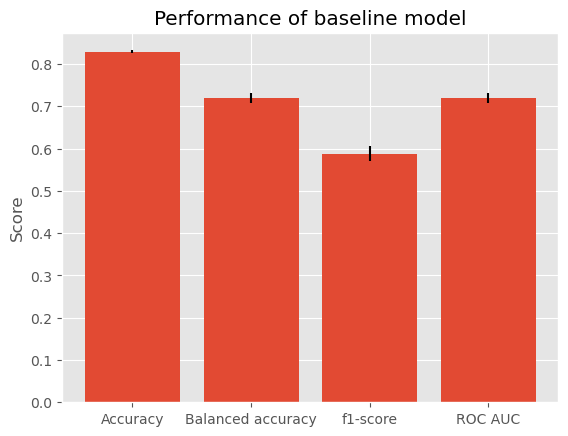

In [26]:
perf_base = tracker_base.get_mean_performance()
fig, ax = plt.subplots()
ax.bar(perf_base.keys(), [v[0] for v in perf_base.values()], yerr=[v[1] for v in perf_base.values()])
ax.set_title('Performance of baseline model')
ax.set_ylabel('Score')
savefig('baseline_performance.svg')

Text(0, 0.5, 'Score')

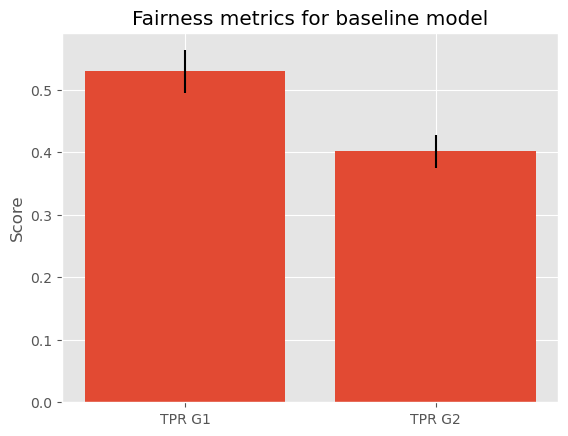

In [27]:
fairness_base = tracker_base.get_mean_fairness()
fig, ax = plt.subplots()
ax.bar(fairness_base.keys(), [v[0] for v in fairness_base.values()], yerr=[v[1] for v in fairness_base.values()])
ax.set_title('Fairness metrics for baseline model')
ax.set_ylabel('Score')

We use the final model for evaluating feature importance. Since we're using a logistic regression model, we can calculate the odds ratio between $x$ and $x'$, where $x$ and $x'$ are identical except for one feature, as:

$$
\frac{odds(x')}{odds(x)} = e^{\beta_j}
$$


Text(0.5, 0.98, 'Baseline - Feature importance for income > 50k')

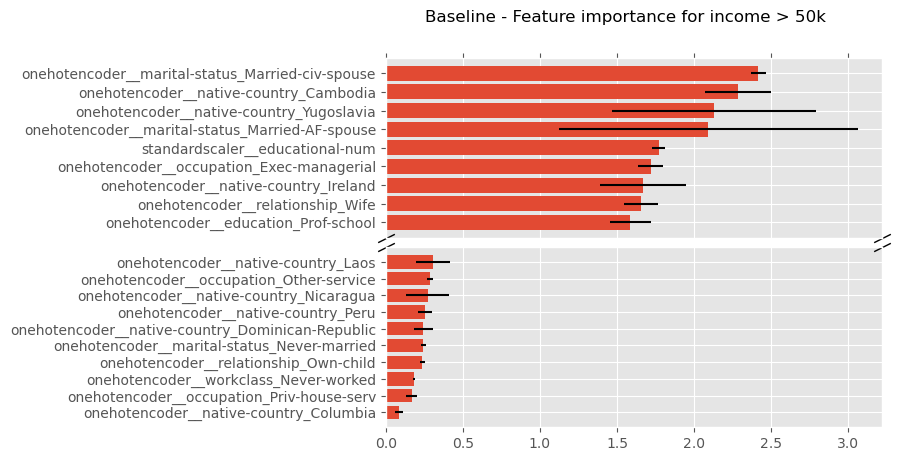

In [48]:
def plot_feature_importance(feature_importance):

    means = np.array([value[0] for value in feature_importance.values()])
    stds = np.array([value[1] for value in feature_importance.values()])
    keys = np.array(list(feature_importance.keys()))

    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.subplots_adjust(hspace=0.05)
    idx = np.argsort(means)
    idx = np.concatenate((idx[:10], idx[-10:]))

    ax1.barh(keys[idx[10:]], means[idx[10:]], xerr=stds[idx[10:]])
    ax2.barh(keys[idx[:10]], means[idx[:10]], xerr=stds[idx[:10]])

    ax1.xaxis.tick_top()

    d = .5
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

    return fig, (ax1, ax2)

feature_importance_base = tracker_base.get_mean_feature_importance()
fig, (ax1, ax2) = plot_feature_importance(feature_importance_base)
fig.suptitle('Baseline - Feature importance for income > 50k')
# savefig('baseline_feature_importance.svg')

### Fair model - enforcing fairness through a loss constraint

To make models fair according to ***Equalized Odds***, we implement the group fairness constraint from:

Richard Berk, Hoda Heidari, Shahin Jabbari, Matthew Joseph, Michael Kearns, Jamie Morgenstern, Seth
Neel, and Aaron Roth. A convex framework for fair regression. arXiv preprint arXiv:1706.02409, 2017.

$$
f_2(\mathbf{w}, S)=\left(\frac{1}{n_1 n_2} \sum_{\substack{\left(\mathbf{x}_i, y_i\right) \in S_1 \\\left(\mathbf{x}_j, y_j\right) \in S_2}} d\left(y_i, y_j\right)\left(\mathbf{w} \cdot \mathbf{x}_i-\mathbf{w} \cdot \mathbf{x}_j\right)\right)^2
$$

This cost function does not work in our setting. We see that dividng by $n_1n_2$ before squaring leads to a tiny penalty, which has no effect on the classifier. Instead, we implement the loss as:

$$
f_2(\mathbf{w}, S)=\frac{1}{n_1 n_2} \left(\sum_{\substack{\left(\mathbf{x}_i, y_i\right) \in S_1 \\\left(\mathbf{x}_j, y_j\right) \in S_2}} d\left(y_i, y_j\right)\left(\mathbf{w} \cdot \mathbf{x}_i-\mathbf{w} \cdot \mathbf{x}_j\right)\right)^2
$$

In [31]:
class GroupFairnessConstraint(nn.Module):
    def __init__(self):
        super(GroupFairnessConstraint, self).__init__()
        
    
    def forward(self, y_pred, y_true, groups):
        mask = groups == 0
        S_pred_1, S_true_1 = y_pred[mask],  y_true[mask]
        S_pred_2, S_true_2 = y_pred[~mask], y_true[~mask]
        
        n_1 = S_pred_1.shape[0]
        n_2 = S_pred_2.shape[0]

        idx1 = torch.arange(n_1)
        idx2 = torch.arange(n_2)

        idx1 = idx1.view(-1, 1)
        idx2 = idx2.view(1, -1)

        idx1 = idx1.repeat(1, idx2.size(1))
        idx2 = idx2.repeat(idx1.size(0), 1)

        result = torch.stack((idx1, idx2), dim=2).view(-1, 2)
        idx1 = result[:, 0]
        idx2 = result[:, 1]
        
        vector = self.d(S_true_1[idx1], S_true_2[idx2]) * (S_pred_1[idx1] - S_pred_2[idx2])
        cost = vector.sum() ** 2
        cost = cost / (n_1*n_2)

        return cost
        
    def d(self, y_i, y_j):
        return (y_i == y_j).int()
    
class FairBinaryLogisticRegression(BinaryLogisticRegression):
    def __init__(self, in_dim: int, gamma: float = 1e-4):
        super().__init__(in_dim)
        self.gamma = gamma
    
    def fit(self, x, y, g, batch_size=64, n_iter=10):
        criterion = nn.BCELoss()
        fair_criterion = GroupFairnessConstraint()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

        trainloader = DataLoader(TensorDataset(x, y, g), batch_size=batch_size, shuffle=True)
        
        for epoch in range(n_iter):
            for x, y, g in trainloader:
                y_pred = self(x)
                loss = criterion(y_pred, y) + self.gamma * fair_criterion(y_pred, y, g)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


In [32]:
tracker_fair = KfoldTracker()

gamma = 5e-3

n_splits = 5
splits = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(splits.split(income_train)):
    train = income_train.iloc[train_idx]
    val = income_train.iloc[val_idx]
    
    x_train = preprocessing.fit_transform(train).toarray()
    y_train = train[target].values
    g_train = train[groups].values
    
    x_val = preprocessing.transform(val).toarray()
    y_val = val[target].values
    g_val = val[groups].values

    x_train, y_train, g_train, x_val, y_val, g_val = map(lambda x: torch.tensor(x, dtype=torch.float), (x_train, y_train, g_train, x_val, y_val, g_val))

    model = FairBinaryLogisticRegression(x_train.shape[1], gamma=gamma)
    model.fit(x_train, y_train, g_train)
    
    y_pred = model(x_val)
    y_pred = y_pred.detach().numpy().round()

    feature_importance = torch.exp(model.linear.weight).detach().numpy().squeeze()    
    feature_names = preprocessing.get_feature_names_out()
    tracker_fair.log(y_val, y_pred, g_val, feature_importance, feature_names)
    
tracker_fair

                          0         1         2         3         4
Accuracy           0.822905  0.822137  0.831222  0.828769  0.832608
Balanced accuracy  0.707133  0.703941  0.697619  0.700257  0.710329
f1-score           0.571517  0.563442  0.555743  0.559289  0.574219
ROC AUC            0.707133  0.703941  0.697619  0.700257  0.710329

               0         1         2         3         4
TPR G1  0.475138  0.473750  0.450731  0.450126  0.475556
TPR G2  0.496667  0.484321  0.393220  0.472222  0.500000

                                                      0         1         2  \
onehotencoder__workclass_?                     0.665826  0.561475  0.513863   
onehotencoder__workclass_Federal-gov           1.243474  1.200113  1.225340   
onehotencoder__workclass_Local-gov             0.613977  0.636686  0.638163   
onehotencoder__workclass_Never-worked          0.194341  0.200321  0.293295   
onehotencoder__workclass_Private               0.821641  0.787990  0.757870   
...          

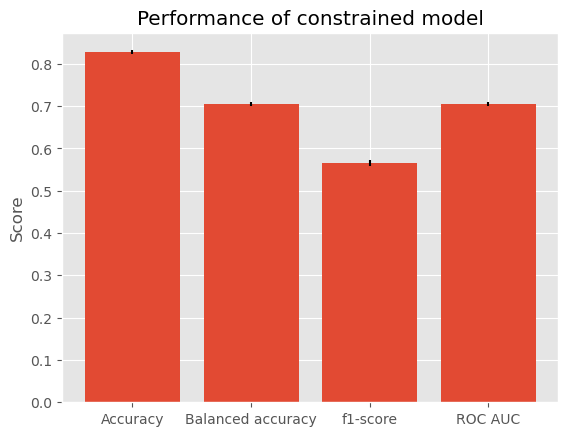

In [33]:
perf_fair = tracker_fair.get_mean_performance()
fig, ax = plt.subplots()
ax.bar(perf_fair.keys(), [v[0] for v in perf_fair.values()], yerr=[v[1] for v in perf_fair.values()])
ax.set_title('Performance of constrained model')
ax.set_ylabel('Score')
savefig('constrained_performance.svg')

Text(0, 0.5, 'Score')

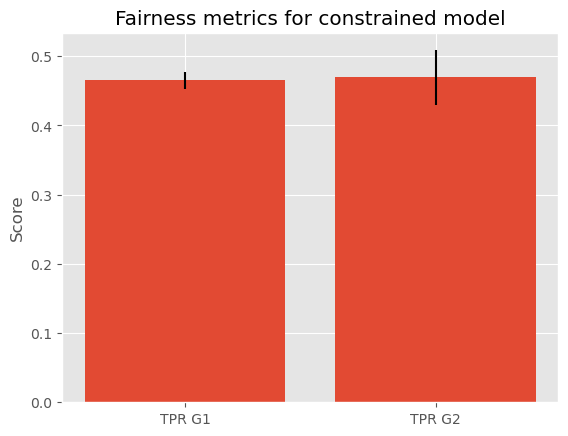

In [34]:
fairness_fair = tracker_fair.get_mean_fairness()
fig, ax = plt.subplots()
ax.bar(fairness_fair.keys(), [v[0] for v in fairness_fair.values()], yerr=[v[1] for v in fairness_fair.values()])
ax.set_title('Fairness metrics for constrained model')
ax.set_ylabel('Score')

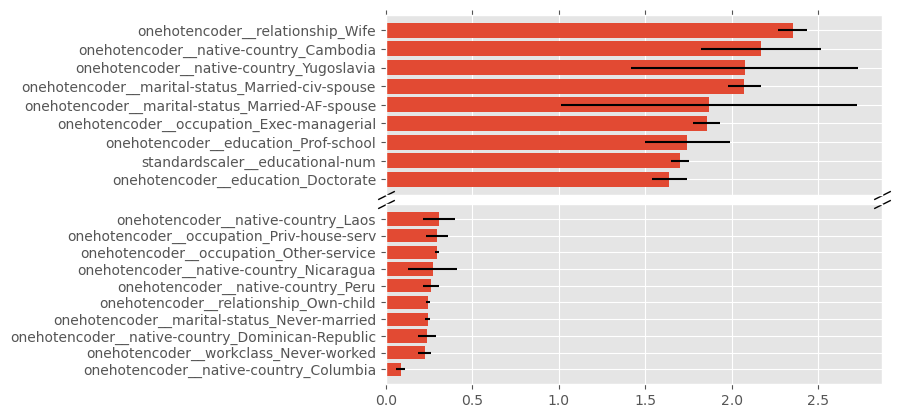

In [49]:
feature_importances_fair = tracker_fair.get_mean_feature_importance()
fig, (ax1, ax2) = plot_feature_importance(feature_importances_fair)

### Comparison of baseline and fair model

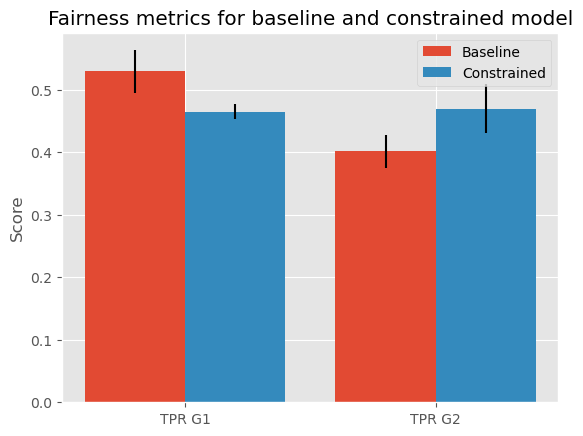

In [36]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(fairness_base.keys())) - .2, [v[0] for v in fairness_base.values()], yerr=[v[1] for v in fairness_base.values()], width=.4, label='Baseline')
ax.bar(np.arange(len(fairness_fair.keys())) + .2, [v[0] for v in fairness_fair.values()], yerr=[v[1] for v in fairness_fair.values()], width=.4, label='Constrained')
ax.set_title('Fairness metrics for baseline and constrained model')
ax.set_ylabel('Score')

ax.set_xticks(np.arange(len(fairness_base.keys())))
ax.set_xticklabels(fairness_base.keys())

ax.legend()
savefig('fairness_comparison.svg')

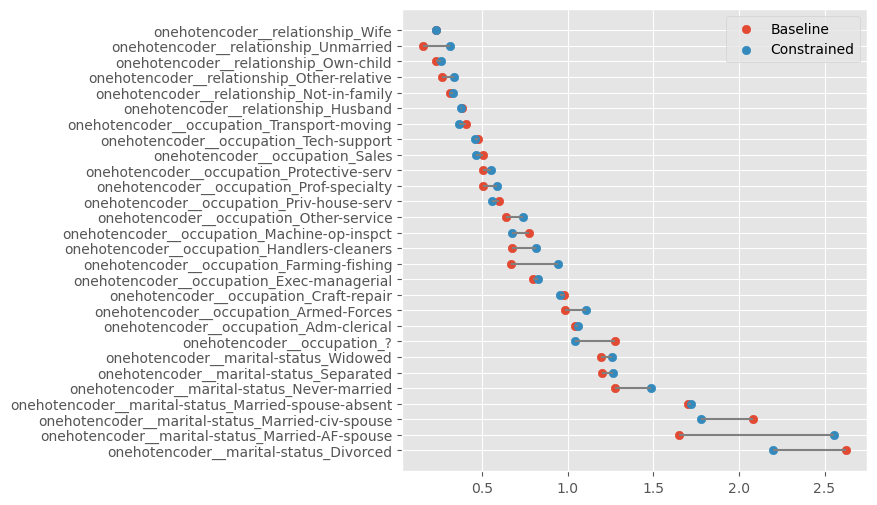

In [39]:
mask = [True if 'marital' in col or 'occupation' in col or 'relationship' in col else False for col in preprocessing.get_feature_names_out()]

y = np.arange(len(feature_importance_fair[mask]))
fig, ax = plt.subplots(figsize=(6, 6))

X = np.vstack((feature_importance_base[mask], feature_importance_fair[mask])).T
idx = np.argsort(-np.mean(X, axis=1))
x1 = feature_importance_base[mask][idx]
x2 = feature_importance_fair[mask][idx]

for n in y:
    a = min(x1[n], x2[n])
    b = max(x1[n], x2[n])
    ax.hlines(n, a, b, color='grey')

ax.scatter(x1, y, label='Baseline')
ax.scatter(x2, y, label='Constrained')

ax.set_yticks(y)
ax.set_yticklabels(preprocessing.get_feature_names_out()[mask])

ax.legend()
savefig('feature_importance_comparison5.svg')